# Is there a statistically significant difference in performance scores between the fast and low stroke rate 1-min-rowing-sessions for each participant？
## t-Test
The goal of this analysis is to compare the **performance metrics** between two **1-minute** rowing sessions of **the same participant**, performed at **different stroke rates (“fast” vs. “low”)**.

Specifically, we use **Welch’s t-tests** to evaluate whether there are statistically significant differences in the following scores between the two sessions:
- torso_angle_score
- sequence_score
- tech_qual_score

A lower p-value (typically p < 0.05) indicates a significant difference between the fast and low sessions for that metric.

The **Welch’s t-test** is an adaptation of the traditional Student’s t-test designed for situations where the two samples may have unequal variances or unequal sample sizes.

The classical Student’s t-test assumes:
	1.	The two groups come from normally distributed populations.
	2.	The two populations have equal variances (homoscedasticity).
	3.	The samples are independent.

However, in real-world biomechanical data — like your rowing sessions — these assumptions often do not hold:
- The fast rowing session may produce more variable scores due to higher movement instability.
- The low session may have more consistent scores but a slightly different number of frames or valid samples.
- In this case, the assumption of equal variance is violated (heteroscedasticity).

Welch’s t-test corrects for this by:
- Estimating the degrees of freedom differently (using the Welch–Satterthwaite equation),
- Allowing each group to have its own variance estimate,
- Adjusting the p-value calculation accordingly.

As a result, Welch’s t-test:
- Provides more accurate Type I error control when variances differ.
- Is more conservative (less likely to falsely detect a difference).
- Performs equally well as Student’s t-test when variances are equal (so it’s a safe default choice).

## Single Participant (t-test)

In [7]:
import pandas as pd
from scipy.stats import ttest_ind, t
from pathlib import Path
import numpy as np

# === 1. Define file paths ===
fast_path = Path("/Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/tech_quality_scores/a01_1_fast_tech_quality_score.csv")
low_path  = Path("/Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/tech_quality_scores/a01_1_low_tech_quality_score.csv")

# === 2. Load data ===
fast = pd.read_csv(fast_path)
low  = pd.read_csv(low_path)

# === 3. Extract metadata ===
participant_id = fast_path.stem.split("_")[0]
fast_stroke_rate = fast["stroke_rate"].mean()
low_stroke_rate = low["stroke_rate"].mean()

# === 4. Define metrics to compare ===
metrics = ["torso_angle_score", "sequence_score", "tech_qual_score"]

# === 5. Perform t-test, effect size, and CI ===
results = []
for metric in metrics:
    x = fast[metric].dropna()
    y = low[metric].dropna()

    nx, ny = len(x), len(y)
    mean_x, mean_y = x.mean(), y.mean()
    var_x, var_y = x.var(ddof=1), y.var(ddof=1)
    
    # Welch's t-test
    t_stat, p_val = ttest_ind(x, y, equal_var=False)
    
    # Mean diff and SE
    diff = mean_x - mean_y
    se = np.sqrt(var_x/nx + var_y/ny)
    
    # Degrees of freedom
    df = (var_x/nx + var_y/ny)**2 / ((var_x/nx)**2/(nx-1) + (var_y/ny)**2/(ny-1))
    
    # 95% CI
    ci_low = diff - t.ppf(0.975, df) * se
    ci_high = diff + t.ppf(0.975, df) * se
    
    # Effect size (Cohen's d)
    pooled_sd = np.sqrt(((nx - 1)*var_x + (ny - 1)*var_y) / (nx + ny - 2))
    cohen_d = diff / pooled_sd
    
    results.append({
        "participant_id": participant_id,
        "n_fast": nx,
        "n_low": ny,
        "low_stroke_rate": low_stroke_rate,
        "fast_stroke_rate": fast_stroke_rate,
        "metric": metric,
        "mean_fast": mean_x,
        "mean_low": mean_y,
        "mean_diff (fast - low)": diff,
        "t_statistic": t_stat,
        "df": df,
        "p_value": p_val,
        "95%_CI_lower": ci_low,
        "95%_CI_upper": ci_high,
        "cohen_d": cohen_d
    })

# === 6. Display results ===
results_df = pd.DataFrame(results)
display(results_df)

,participant_id,n_fast,n_low,low_stroke_rate,fast_stroke_rate,metric,mean_fast,mean_low,mean_diff (fast - low),t_statistic,df,p_value,95%_CI_lower,95%_CI_upper,cohen_d
0,a01,30,21,20.34,30.09,torso_angle_score,8.918319,9.004830,-0.086511,-1.725570,48.963756,0.090732,-0.187262,0.014240,-0.459060
1,a01,30,21,20.34,30.09,sequence_score,0.366667,0.857143,-0.490476,-4.126151,48.872259,0.000143,-0.729370,-0.251582,-1.111694
2,a01,30,21,20.34,30.09,tech_qual_score,78.679887,89.181497,-10.501609,-4.432969,48.787552,0.000053,-15.262775,-5.740443,-1.172082


## Batch (t-test)

In [11]:
import pandas as pd
from scipy.stats import ttest_ind, t
from pathlib import Path
import numpy as np

# === 1. Define base directory ===
BASE_DIR = Path("/Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/tech_quality_scores")

# === 2. Find all _fast_ files and match with corresponding _low_ ===
fast_files = list(BASE_DIR.glob("*_fast_tech_quality_score.csv"))
results = []

for fast_path in fast_files:
    # Build matching low file path
    low_path = Path(str(fast_path).replace("_fast_", "_low_"))
    if not low_path.exists():
        print(f"⚠️ Skipping {fast_path.name}: no matching low file found.")
        continue

    # Load data
    fast = pd.read_csv(fast_path)
    low  = pd.read_csv(low_path)

    # Extract metadata
    participant_id = fast_path.stem.split("_")[0]
    fast_stroke_rate = fast["stroke_rate"].mean()
    low_stroke_rate = low["stroke_rate"].mean()

    # Define metrics
    metrics = ["torso_angle_score", "sequence_score", "tech_qual_score"]

    # Perform t-tests
    for metric in metrics:
        x = fast[metric].dropna()
        y = low[metric].dropna()

        nx, ny = len(x), len(y)
        mean_x, mean_y = x.mean(), y.mean()
        var_x, var_y = x.var(ddof=1), y.var(ddof=1)

        # Welch’s t-test
        t_stat, p_val = ttest_ind(x, y, equal_var=False)

        # Mean diff and SE
        diff = mean_x - mean_y
        se = np.sqrt(var_x/nx + var_y/ny)

        # Degrees of freedom
        df = (var_x/nx + var_y/ny)**2 / ((var_x/nx)**2/(nx-1) + (var_y/ny)**2/(ny-1))

        # 95% CI
        ci_low = diff - t.ppf(0.975, df) * se
        ci_high = diff + t.ppf(0.975, df) * se

        # Effect size (Cohen’s d)
        pooled_sd = np.sqrt(((nx - 1)*var_x + (ny - 1)*var_y) / (nx + ny - 2))
        cohen_d = diff / pooled_sd

        # Append results
        results.append({
            "metric": metric,
            "participant_id": participant_id,
            "n_fast": nx,
            "n_low": ny,
            "low_stroke_rate": low_stroke_rate,
            "fast_stroke_rate": fast_stroke_rate,
            "mean_fast": mean_x,
            "mean_low": mean_y,
            "mean_diff (fast - low)": diff,
            "95%_CI_lower": ci_low,
            "95%_CI_upper": ci_high,
            "t_statistic": t_stat,
            "df": df,
            "p_value": p_val,
            "cohen_d": cohen_d
        })

# === 3. Combine all results into one DataFrame ===
results_df = pd.DataFrame(results)

# === 4. Sort results by metric, then by participant_id ===
results_df = results_df.sort_values(by=["metric", "participant_id"]).reset_index(drop=True)

# === 5. Reorder columns for readability ===
column_order = [
    "metric", "participant_id",
    "n_fast", "n_low",
    "low_stroke_rate", "fast_stroke_rate",
    "mean_fast", "mean_low", "mean_diff (fast - low)",
    "95%_CI_lower", "95%_CI_upper",
    "t_statistic", "df", "p_value", "cohen_d"
]
results_df = results_df[column_order]

# === 6. Create output directory and save ===
output_dir = Path("/Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/statistical_analysis")
output_dir.mkdir(parents=True, exist_ok=True)
output_path = output_dir / "batch_ttest_results.csv"

display(results_df)
results_df.to_csv(output_path, index=False)
print(f"✅ Results saved to: {output_path}")

,metric,participant_id,n_fast,n_low,low_stroke_rate,fast_stroke_rate,mean_fast,mean_low,mean_diff (fast - low),95%_CI_lower,95%_CI_upper,t_statistic,df,p_value,cohen_d
0,sequence_score,a01,30,21,20.34,30.09,0.366667,0.857143,-0.490476,-0.729370,-0.251582,-4.126151,48.872259,1.429842e-04,-1.111694
1,sequence_score,a02,22,20,20.18,29.82,0.000000,0.400000,-0.400000,-0.635236,-0.164764,-3.559026,19.000000,2.094822e-03,-1.154701
2,sequence_score,a03,34,20,20.15,34.32,0.000000,0.250000,-0.250000,-0.457921,-0.042079,-2.516611,19.000000,2.099150e-02,-0.930949
3,sequence_score,a04,31,20,20.47,31.64,0.870968,0.550000,0.320968,0.056451,0.585484,2.478356,29.931594,1.906277e-02,0.773653
4,sequence_score,a05,30,19,19.94,30.05,0.966667,0.947368,0.019298,-0.107581,0.146178,0.309767,32.127663,7.587385e-01,0.095629
5,sequence_score,a06,30,20,20.22,30.10,0.000000,0.950000,-0.950000,-1.054651,-0.845349,-19.000000,19.000000,8.074624e-14,-6.752777
6,tech_qual_score,a01,30,21,20.34,30.09,78.679887,89.181497,-10.501609,-15.262775,-5.740443,-4.432969,48.787552,5.267707e-05,-1.172082
7,tech_qual_score,a02,22,20,20.18,29.82,55.189774,66.868919,-11.679145,-16.492228,-6.866063,-5.038829,21.521880,5.101815e-05,-1.623936
8,tech_qual_score,a03,34,20,20.15,34.32,56.939843,60.384596,-3.444753,-8.329040,1.439534,-1.470471,20.150025,1.568780e-01,-0.529080
9,tech_qual_score,a04,31,20,20.47,31.64,80.170866,76.940953,3.229914,-2.915343,9.375170,1.077300,27.619863,2.906662e-01,0.343859


✅ Results saved to: /Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/statistical_analysis/batch_ttest_results.csv


## Data Visualization – mean difference barplot

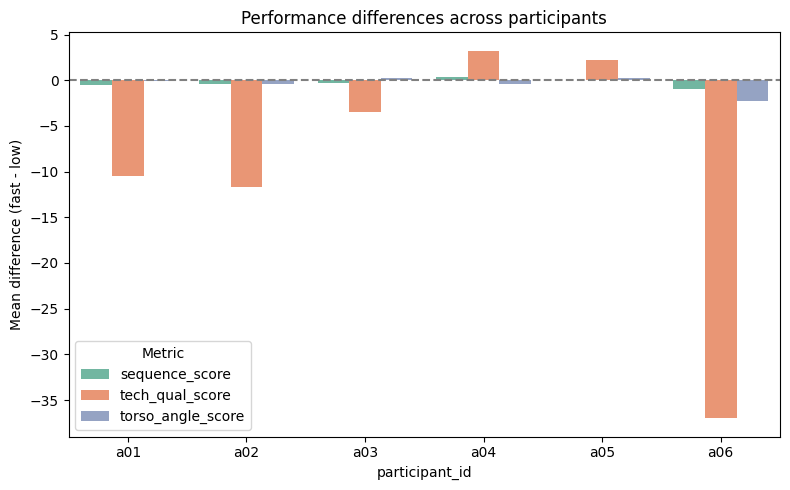

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.barplot(
    data=results_df,
    x="participant_id",
    y="mean_diff (fast - low)",
    hue="metric",
    palette="Set2"
)
plt.axhline(0, color="gray", linestyle="--")
plt.ylabel("Mean difference (fast - low)")
plt.title("Performance differences across participants")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

# Merge all .csv file to one

| participant_id | expertise_level | session_time | speed_type | stroke_rate | stroke_id | torso_angle_score | sequence_score | tech_qual_score | source_file |
|----------------|-----------------|---------------|-------------|--------------|------------|-------------------|----------------|----------------|--------------|
| a02 | novice | 1 | low | 20.18 | 1 | 6.875929 | 0 | 55.007435 | a02_1_low_tech_quality_score.csv |
| a02 | novice | 1 | low | 20.18 | 2 | 7.347756 | 1 | 78.782050 | a02_1_low_tech_quality_score.csv |
| a02 | novice | 1 | low | 20.18 | 3 | 7.475405 | 0 | 59.803242 | a02_1_low_tech_quality_score.csv |
| a02 | novice | 1 | low | 20.18 | 4 | 7.039500 | 1 | 76.316000 | a02_1_low_tech_quality_score.csv |
| a02 | novice | 1 | low | 20.18 | 5 | 7.409104 | 0 | 59.272829 | a02_1_low_tech_quality_score.csv |
| ... | ... | ... | ... | ... | ... | ... | ... | ... | ... |

- Rows: each stroke (1002 total)
- Columns: 10 (participant_id, expertise_level, session_time, speed_type, stroke_rate, stroke_id, torso_angle_score, sequence_score, tech_qual_score, source_file)

In [12]:
import pandas as pd
from pathlib import Path

# === 设置你的文件夹路径 ===
data_dir = Path("/Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/tech_quality_scores")

# === 找出所有符合命名的文件 ===
files = list(data_dir.glob("*_tech_quality_score.csv"))
print(f"Found {len(files)} files.")

# === 逐个读取并合并 ===
dfs = []
for file in files:
    df = pd.read_csv(file)
    df["source_file"] = file.name  # 保存原文件名，方便追溯
    dfs.append(df)

merged_df = pd.concat(dfs, ignore_index=True)
print(f"Merged shape: {merged_df.shape}")

# === 导出合并后的文件 ===
out_path = data_dir / "merged_strokes_all.csv"
merged_df.to_csv(out_path, index=False)
print(f"✅ Merged dataset saved to: {out_path}")

Found 24 files (excluded: 1).
Merged shape: (1002, 10)
✅ Merged dataset saved to: /Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/tech_quality_scores/merged_strokes_all.csv


# Mixed-Effects Model
### Data Structure –– hierarchical (nested)
| Level | Unit | Example|
|-----|----|----|
|Level 2| Participant(`partipant_id`)|a01, a02, ...|
|Level 1| Session (`speed_type`, `session_time`)| high/low; 1/2/4 min|
|Level 0| Stroke (`stroke_id`) | Each row 

Repeated measurements are **nested within each participant**, which is why we use a **Linear Mixed-Effects Model(LMM)**.

### Variable definitions
| Variable | Type | Description | Use in the model|
|-----------|------|-------------|----------------|
| `participant_id` | Categorical(nominal) | Participant identifier | Random effect – accounts for between participant differences|
|`expertise_level`|Categorical (ordinal) | Skill level of participants (beginner, novice, intermediate) | Fixed effect — used for between-subject differences|
| `speed_type` | Categorical | High ≥ 28 SPM, Low = 18–21 SPM| Fixed effect – tests within-subject speed effects|
| `session_time` | Categorical | Session duration (1, 2, 4 min) | Fixed effect — tests within-subject fatigue effects |
| `torso_angle_score` | Numeric (continuous) | Torso angle measurement | Response variable|
| `sequence_score`| Numeric (binary) | Indicates correct stroke sequencing | Response variable | 
| `tech_qual_score` | Numeric (continuous) | Overall technique quality for the stroke | Response variable|

## Linear Mixed-Effects Models (torso angle score & technique quality score)
### Model Framework
For any stroke $k$ in session $j$ for participant $i$, the general form is:

\begin{equation}
y_{ijk} = \beta_0 + \beta_1 X_{1,ijk} + \beta_2 X_{2,ijk} + \ldots + u_{0i} + \varepsilon_{ijk}
\end{equation}

where:
- $y_{ijk}$: torso angle score (or technique quality score)
- $X_{1,ijk}, X_{2,ijk}$: fixed-effect predictors (speed, duration, expertise, etc.)
- $u_{0i} \sim N(0, \sigma_u^2)$: participant-level random intercept
- $\varepsilon_{ijk} \sim N(0, \sigma^2)$: residual error

### Question 1.1: Between-subject differences (torso angle score)
> Do participants with different expertise levels differ in average torso angle score?

**Model formula:**
\begin{equation}
\text{torso\_angle\_score}_{ijk} = \beta_0 + \beta_1(\text{expertise\_level}_i) + u_{0i} + \varepsilon_{ijk}
\end{equation}

**Interpretation:**
- The fixed effect $\beta_1$ tests whether expertise level predicts higher or lower torso angle score
- The random intercept $u_{0i}$ allows each participant to have a unique baseline.

In [14]:
# code for q1
import pandas as pd
import statsmodels.formula.api as smf

# === Load data ===
df = pd.read_csv("/Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/tech_quality_scores/merged_strokes_all.csv")
df["participant_id"] = df["participant_id"].astype("category")
df["expertise_level"] = df["expertise_level"].astype("category")

# excluce a02
df = df[ (df["participant_id"] != "a02")].copy()

# === LMM: Expertise level effect ===
model1 = smf.mixedlm(
    "torso_angle_score ~ expertise_level",
    data=df,
    groups=df["participant_id"]
).fit()

print(model1.summary())

                  Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    torso_angle_score
No. Observations:      846        Method:                REML             
No. Groups:            5          Scale:                 0.4257           
Min. group size:       166        Log-Likelihood:        -850.5867        
Max. group size:       173        Converged:             Yes              
Mean group size:       169.2                                              
--------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                        7.860    0.723 10.872 0.000  6.443  9.277
expertise_level[T.intermediate] -0.013    1.022 -0.013 0.990 -2.017  1.991
expertise_level[T.novice]        0.793    1.252  0.634 0.526 -1.661  3.248
Group Var                        1.043    1.

#### Interpretation for Q1.1 (torso angle score)
> Do participants with different expertise levels differ in average torso angle score?

Notes: Exclude a02, because the 1-minute fast-rate data is incomplete

 - Mean torso-angle score for **beginners** is about 7.908
 - Intermediate rowers score about **0.013 units lower** than beginners on average — an extremely small and **non-significant** difference (p = 0.99).
 - Novices score about **0.79 units higher** than beginners — also **not significant** (p = 0.53).
- Participants vary substantially in their baseline torso-angle scores. This reflects genuine between-person posture differences.

**Summary:**

After accounting for repeated strokes within each participant, **expertise level does not significantly affect torso-angle scores**.

Although novices show a slightly higher mean posture angle and intermediates slightly lower, both effects are statistically indistinguishable from zero (p > 0.5).

**Conclusion**
> Across all strokes, posture quality (torso-angle score) is similar among beginners, novices, and intermediates. The main source of variation comes from individual participant differences rather than formal expertise level.

-----------

### Question 1.2: Within-subject fatigue effects  (torso angle score)
> Does torso angle score decline in longer sessions (1 vs. 2 vs. 4 minutes)? (`speed_type` are all `low`)

**Model formula**
\begin{equation}
\text{torso\_angle\_score}_{ijk} = \beta_0 + \beta_1(\text{session\_time}_{ij}) + u_{0i} + \varepsilon_{ijk}
\end{equation}

**Interpretation:**
- The fixed effect $\beta_1$ captures the slope of fatigue — if negative, it indicates that as session duration increases, torso angle quality declines.
- The random intercept $u_{0i}$ allows each participant to have a unique baseline.

In [16]:
# code for q2
import pandas as pd
import statsmodels.formula.api as smf

# === Load data ===
df = pd.read_csv("/Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/tech_quality_scores/merged_strokes_all.csv")
df["participant_id"] = df["participant_id"].astype("category")
df["session_time"] = df["session_time"].astype("category")

# === ✅ Filter: only keep low-speed sessions ===
df = df[df["speed_type"] == "low"].copy()

# === LMM: Session duration effect ===
model2 = smf.mixedlm(
    "torso_angle_score ~ session_time",
    data=df,
    groups=df["participant_id"]
).fit()

print(model2.summary())

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: torso_angle_score
No. Observations: 825     Method:             REML             
No. Groups:       6       Scale:              0.3490           
Min. group size:  132     Log-Likelihood:     -755.2461        
Max. group size:  143     Converged:          Yes              
Mean group size:  137.5                                        
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             8.085    0.298 27.154 0.000  7.501  8.668
session_time[T.2]    -0.087    0.066 -1.316 0.188 -0.217  0.043
session_time[T.4]    -0.124    0.060 -2.049 0.040 -0.242 -0.005
Group Var             0.514    0.555                           



#### Interpretation for Q1.2 (torso angle score)
> Does torso angle score decline in longer sessions (1 vs. 2 vs. 4 minutes)?

Notes: exclude fast-rate session

- In **1-mintute** session, the model estimates that the average torso angle score is about 8.085.
- **2-minute** sessions are on average **0.087 points lower** than 1-minute sessions — **not significant (p = 0.188)**.
- **4-minute** sessions are on average **0.124 units lower** than 1-minute sessions — this effect is **statistically significant (p = 0.040)**.
- Participants vary moderately in their baseline posture.

**Conclusion**
> When analyzing all strokes within low-speed sessions, torso-angle stability declines slightly as session duration increases, consistent with a mild fatigue effect.

--------------

### Question 1.3: Within-subject speed effects (torso angle score)
> Does a higher stroke rate (high speed) reduce the average torso angle score?

**Model formula**
\begin{equation}
\text{torso\_angle\_score}_{ijk} = \beta_0 + \beta_1(\text{speed\_type}_{ij}) + u_{0i} + \varepsilon_{ijk}
\end{equation}

**Interpretation:**
- The fixed effect $\beta_1$ estimates the difference in mean torso angle between high and low speed sessions. 	If $\beta_1 < 0$, faster stroke rate leads to poorer posture control.
- The random intercept $u_{0i}$ allows each participant to have a unique baseline.

In [17]:
# code for q3
import pandas as pd
import statsmodels.formula.api as smf

# === Load data ===
df = pd.read_csv("/Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/tech_quality_scores/merged_strokes_all.csv")
df["participant_id"] = df["participant_id"].astype("category")
df["speed_type"] = df["speed_type"].astype("category")

# === ✅ Filter: only keep 1-minute sessions and exclude "a02" ===
df = df[(df["session_time"] == 1) & (df["participant_id"] != "a02")].copy()

# === LMM: Speed type effect ===
model3 = smf.mixedlm(
    "torso_angle_score ~ speed_type",
    data=df,
    groups=df["participant_id"]
).fit()

print(model3.summary())

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: torso_angle_score
No. Observations: 255     Method:             REML             
No. Groups:       5       Scale:              0.3300           
Min. group size:  49      Log-Likelihood:     -233.1454        
Max. group size:  54      Converged:          Yes              
Mean group size:  51.0                                         
---------------------------------------------------------------
                      Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             7.769    0.396 19.633 0.000  6.993  8.544
speed_type[T.low]     0.458    0.074  6.220 0.000  0.314  0.603
Group Var             0.772    0.965                           



#### Interpretation for Q1.3 (torso angle score)
>Does a higher stroke rate (high speed) reduce the average torso angle score?

Notes: only keep 1-minute sessions and exclude "a02"

- Mean torso-angle score during **1-min high-speed** sessions is 7.769
- On average, 1-min **low-speed** sessions have torso-angle scores **0.458 units higher** than high-speed ones — **a statistically significant difference**.
- Moderate between-participant variation.

**Summary:**
When analyzing all strokes from 1-minute sessions (excluding participant "a02"), rowers show significantly better torso-angle scores at low speed than at high speed.


**Conclusion**
> Lower stroke rates (~18–21 SPM) are associated with improved posture stability, while higher rates (≥ 28 SPM) reduce torso-angle quality. This effect is robust and statistically significant (p < 0.001), even after accounting for individual baseline differences.

------------- 

### Question 3.1: Between-subject differences (technique quality score)
> Do participants with different expertise levels differ in average technique quality score?

**Model formula:**
\begin{equation}
\text{tech\_qual\_score}_{ijk} = \beta_0 + \beta_1(\text{expertise\_level}_i) + u_{0i} + \varepsilon_{ijk}
\end{equation}

**Interpretation:**
- The fixed effect $\beta_1$ tests whether expertise level predicts higher or lower technique quality score
- The random intercept $u_{0i}$ allows each participant to have a unique baseline.

In [18]:
# code for q1
import pandas as pd
import statsmodels.formula.api as smf

# === Load data ===
df = pd.read_csv("/Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/tech_quality_scores/merged_strokes_all.csv")
df["participant_id"] = df["participant_id"].astype("category")
df["expertise_level"] = df["expertise_level"].astype("category")

# excluce a02
df = df[ (df["participant_id"] != "a02")].copy()

# === LMM: Expertise level effect ===
model1 = smf.mixedlm(
    "tech_qual_score ~ expertise_level",
    data=df,
    groups=df["participant_id"]
).fit()

print(model1.summary())

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
                   Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     tech_qual_score
No. Observations:       846         Method:                 REML           
No. Groups:             5           Scale:                  123.6225       
Min. group size:        166         Log-Likelihood:         -3240.3750     
Max. group size:        173         Converged:              Yes            
Mean group size:        169.2                                              
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z   P>|z|  [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        73.978    8.802 8.405 0.000  56.726 91.230
expertise_level[T.intermediat

#### Interpretation for Q3.1 (technique quality score)
> Do participants with different expertise levels differ in average technique quality score?

- Mean technique-quality score for `beginners` is **73.978*8.
- `Intermediates` average **1.327 points higher** than beginners – not significant.
- `Novices` average **15.245 points higher** than beginners – not significant.
- Large between-participant variability.

**Summary:**

Across all strokes (excluding a02), expertise level does not significantly affect technique quality score.
Although novices show a substantially higher mean (≈ +15 points), the difference is not statistically reliable (p > 0.3)

**Conclusion**
> Technique quality varies mainly across individuals rather than formal expertise levels; no systematic improvement or decline in overall technique quality is detected between beginners, novices, and intermediates.

-----------

### Question 3.2: Within-subject fatigue effects  (technique quality score)
> Does technique quality score decline in longer sessions (1 vs. 2 vs. 4 minutes)? (`speed_type` are all `low`)

**Model formula**
\begin{equation}
\text{tech\_qual\_score}_{ijk} = \beta_0 + \beta_1(\text{session\_time}_{ij}) + u_{0i} + \varepsilon_{ijk}
\end{equation}

**Interpretation:**
- The fixed effect $\beta_1$ captures the slope of fatigue — if negative, it indicates that as session duration increases, technique quality declines.
- The random intercept $u_{0i}$ allows each participant to have a unique baseline.

In [20]:
# code for q2
import pandas as pd
import statsmodels.formula.api as smf

# === Load data ===
df = pd.read_csv("/Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/tech_quality_scores/merged_strokes_all.csv")
df["participant_id"] = df["participant_id"].astype("category")
df["session_time"] = df["session_time"].astype("category")

# === ✅ Filter: only keep low-speed sessions ===
df = df[df["speed_type"] == "low"].copy()

# === LMM: Session duration effect ===
model2 = smf.mixedlm(
    "tech_qual_score ~ session_time",
    data=df,
    groups=df["participant_id"]
).fit()

print(model2.summary())

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: tech_qual_score
No. Observations: 825     Method:             REML           
No. Groups:       6       Scale:              116.3549       
Min. group size:  132     Log-Likelihood:     -3140.8948     
Max. group size:  143     Converged:          Yes            
Mean group size:  137.5                                      
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          77.860    3.747 20.778 0.000 70.516 85.205
session_time[T.2]  -1.191    1.212 -0.983 0.326 -3.567  1.185
session_time[T.4]   1.131    1.103  1.026 0.305 -1.031  3.293
Group Var          78.432    4.665                           



#### Interpretation for Q3.2 (technique quality score)
>Does technique quality score decline in longer sessions (1 vs. 2 vs. 4 minutes)?

- The average technique quality score for `1-minute` sessions is 77.860.
- `2-minute` sessions are about **1.2 points lower** than 1-minute sessions — not significant.
- `4-minute` sessions are about **1.1 points higher** than 1-minute sessions — also not significant.
- Large individual variation — participants differ considerably in their overall technique scores.

**Summary:**

For low-speed sessions, technique quality scores remain stable across session durations (1, 2, 4 minutes). Neither short nor long sessions show significant differences. The variation in technique is mainly between participants, not due to fatigue or duration.

**Conclusion**
>At lower stroke rates, session duration does not significantly influence overall technique quality — indicating that rowers maintain consistent technical performance even as session time increases.

### Question 3.3: Within-subject speed effects (technique quality score)
> Does a higher stroke rate (high speed) reduce the average technique quality score?

**Model formula**
\begin{equation}
\text{tech\_qual\_score}_{ijk} = \beta_0 + \beta_1(\text{speed\_type}_{ij}) + u_{0i} + \varepsilon_{ijk}
\end{equation}

**Interpretation:**
- The fixed effect $\beta_1$ estimates the difference in mean technique quality score between high and low speed sessions. 	If $\beta_1 < 0$, faster stroke rate leads to poorer posture control.
- The random intercept $u_{0i}$ allows each participant to have a unique baseline.

In [21]:
# code for q3
import pandas as pd
import statsmodels.formula.api as smf

# === Load data ===
df = pd.read_csv("/Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/tech_quality_scores/merged_strokes_all.csv")
df["participant_id"] = df["participant_id"].astype("category")
df["speed_type"] = df["speed_type"].astype("category")

# === ✅ Filter: only keep 1-minute sessions and exclude "a02" ===
df = df[(df["session_time"] == 1) & (df["participant_id"] != "a02")].copy()

# === LMM: Speed type effect ===
model3 = smf.mixedlm(
    "tech_qual_score ~ speed_type",
    data=df,
    groups=df["participant_id"]
).fit()

print(model3.summary())

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: tech_qual_score
No. Observations: 255     Method:             REML           
No. Groups:       5       Scale:              103.9847       
Min. group size:  49      Log-Likelihood:     -960.0895      
Max. group size:  54      Converged:          Yes            
Mean group size:  51.0                                       
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          70.999    5.755 12.336 0.000 59.718 82.279
speed_type[T.low]   9.097    1.308  6.952 0.000  6.532 11.662
Group Var         162.268   11.484                           



#### Interpretation for Q3.3 (technique quality score)
>Does a higher stroke rate (high speed) reduce the average technique quality score?

- Mean technique quality score in 1-minute `high-speed` sessions is 70.999.
- Technique quality scores are, on average, **9.1 points higher** during `low-speed` sessions compared to high-speed sessions — **significant difference**.
- Substantial between-participant variability.

**Summary**

Within 1-minute sessions, technique quality is significantly higher at low speed than at high speed.

**Conclusion**
> Slower stroke rates (18–21 SPM) are associated with better technical execution, while high stroke rates (≥28 SPM) cause a measurable reduction in technique quality. This effect is statistically robust (p < 0.001), even after accounting for individual differences among participants.

## Generalized linear mixed-effects model (sequence score)
### Model Framework
For binary outcomes, we model: 
\begin{equation}
\text{logit}(P(\text{sequence\_score}=1)) = \beta_0 + \beta_1 X + u_{0i}
\end{equation}

where:
- $P(\text{sequence\_score}=1)$: probability of correct squence
- $X$: predictor (`expertise_level`, `session_time`, or `speed_type`)
- $u_{0i}$: random intercept for participant


### Question 2.1: Between-subject differences (sequence score)
>Do participants with different expertise levels differ in the probability of a correct stroke sequence?

**Model Formula**
\begin{equation}
\text{logit}(P(\text{sequence\_score}=1)) = \beta_0 + \beta_1 (\text{expertise\_level}_i) + u_{0i}
\end{equation}

In [24]:
# Question 2.1
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

# === Load data ===
df = pd.read_csv("/Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/tech_quality_scores/merged_strokes_all.csv")
df["expertise_level"] = df["expertise_level"].astype("category")

# === Logistic regression (no random effects) ===
model1 = smf.glm(
    "sequence_score ~ expertise_level",
    data=df,
    family=sm.families.Binomial()
).fit()

print(model1.summary())

# === Convert coefficients to odds ratios ===
print("\nOdds Ratios:\n", model1.params.apply(lambda x: round(np.exp(x), 3)))

                 Generalized Linear Model Regression Results                  
Dep. Variable:         sequence_score   No. Observations:                 1002
Model:                            GLM   Df Residuals:                      999
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -622.17
Date:                Fri, 21 Nov 2025   Deviance:                       1244.3
Time:                        17:58:44   Pearson chi2:                 1.00e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.04358
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

### Interpretation for Q2.1 (sequence score)
>Do participants with different expertise levels differ in the probability of a correct stroke sequence?

- Baseline (beginners). The log-odds correspond to an odds ≈ 1.24 → `beginners` have about a **55 % chance** (≈ 1.24 / (1 + 1.24)) of a correct sequence.
- **Significant positive effect**. Odds ≈ 1.37 → `intermediates` are **1.37 × more likely** than beginners to perform a correct sequence.
- **Strong, significant positive effect**. Odds ≈ 3.04 → `novices` are about **3 × more likely** than beginners to perform a correct sequence.

**Summary**

After accounting for all strokes, expertise level significantly predicts sequence correctness.
Compared with beginners:
- Intermediates show a modest but significant improvement in stroke sequencing accuracy.
- Novices show a large and highly significant improvement — roughly triple the odds of a correct sequence.

**Conclusion**
> Higher expertise levels are associated with a greater likelihood of executing correct stroke sequences. The probability of correct sequencing increases steadily from beginners → intermediates → novices.
-------------

### Question 2.2: Within-subject fatigue effects (sequence score)
> Does the probability of correct sequence change with session duration (1, 2, 4 min) under low-speed sessions?

**Model Formula**
\begin{equation}
\text{logit}(P(\text{sequence\_score}=1)) = \beta_0 + \beta_1 (\text{session\_time}_i) + u_{0i}
\end{equation}

In [25]:
# Question 2.2
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

# === Load data ===
df = pd.read_csv("/Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/tech_quality_scores/merged_strokes_all.csv")

# === Filter low-speed sessions ===
df_low = df[df["speed_type"] == "low"].copy()
df_low["session_time"] = df_low["session_time"].astype("category")

# === Logistic regression ===
model2 = smf.glm(
    "sequence_score ~ session_time",
    data=df_low,
    family=sm.families.Binomial()
).fit()

print(model2.summary())
print("\nOdds Ratios:\n", model2.params.apply(lambda x: round(np.exp(x), 3)))

                 Generalized Linear Model Regression Results                  
Dep. Variable:         sequence_score   No. Observations:                  825
Model:                            GLM   Df Residuals:                      822
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -484.44
Date:                Fri, 21 Nov 2025   Deviance:                       968.88
Time:                        18:00:45   Pearson chi2:                     825.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01814
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.6559      0.19

### Interpretation for Q2.2 (sequence score)
> Does the probability of correct sequence change with session duration (1, 2, 4 min) under low-speed sessions?

- Baseline (1-min sessions). Odds ≈ 1.93 → rowers have about **66 % probability of a correct sequence** at `1 min`.
- `2-min` sessions show a slightly **lower** probability (odds ≈ 0.92 × baseline) — **not significant**.
- `4-min` sessions have **significantly higher** odds (≈ 1.73 × baseline) of a correct sequence — a meaningful improvement.

**Summary**

At low speed, sequence correctness improves slightly with longer sessions.
- There is no difference between 1- and 2-minute sessions.
- The 4-minute sessions show a significant increase in the likelihood of performing the correct sequence (≈ 73 % higher odds than 1-min).

**Conclusion**
> During low-speed rowing, longer sessions (especially 4 minutes) are associated with a higher probability of correct stroke sequencing, suggesting greater rhythm consistency rather than fatigue-related decline.

-----------

### Question 2.3: Within-subject speed effects (sequence score)
>Does stroke speed (high vs low) affect the probability of correct sequence, within 1-minute sessions (excluding a02)?

**Model Formula**
\begin{equation}
\text{logit}(P(\text{sequence\_score}=1)) = \beta_0 + \beta_1 (\text{speed\_type}_i) + u_{0i}
\end{equation}

In [26]:
# Question 2.3
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

# === Load data ===
df = pd.read_csv("/Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/tech_quality_scores/merged_strokes_all.csv")

# === Filter for 1-min sessions and exclude a02 ===
df_speed = df[(df["session_time"] == 1) & (df["participant_id"] != "a02")].copy()
df_speed["speed_type"] = df_speed["speed_type"].astype("category")

# === Logistic regression ===
model3 = smf.glm(
    "sequence_score ~ speed_type",
    data=df_speed,
    family=sm.families.Binomial()
).fit()

print(model3.summary())
print("\nOdds Ratios:\n", model3.params.apply(lambda x: round(np.exp(x), 3)))

                 Generalized Linear Model Regression Results                  
Dep. Variable:         sequence_score   No. Observations:                  255
Model:                            GLM   Df Residuals:                      253
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -166.23
Date:                Fri, 21 Nov 2025   Deviance:                       332.45
Time:                        18:00:46   Pearson chi2:                     255.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.07297
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.2726      0.16

### Interpretation for Q2.3 (sequence score)
> Does stroke speed (high vs low) affect the probability of correct sequence, within 1-minute sessions (excluding a02)?

- Baseline (1-min high-speed sessions). Odds ≈ 0.76 → roughly a **43% chance of correct sequence** at `high speed`.
- **Strong, significant effect**. Odds ≈ 3.22 → `low-speed` sessions are **over 3× more likely** to produce correct sequences than high-speed sessions.

**Summary**

When comparing only 1-minute sessions, speed significantly affects sequence accuracy:
- At low speed, rowers are about three times more likely to maintain the correct stroke sequence.
- At high speed, the probability of correct sequencing drops noticeably.

**Conclusion**
>Higher rowing speed (≥28 SPM) significantly reduces the likelihood of correct sequencing, suggesting that maintaining rhythm and coordination becomes more difficult under faster stroke conditions.